Fit a Lasso regression model to the diabetes data set with λ set so as to optimize performance on a leave-one-out cross-validation of the data set.

In [1]:
import numpy as np
import time
from sklearn.datasets import load_diabetes
from bbai.glm import Lasso
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 600

## Generate Data Set

In [2]:
df = load_diabetes()
X = df['data']
y = df['target']
cols = df['feature_names']
n, p = X.shape

In [3]:
t1 = time.time()
model = Lasso().fit(X, y)
   # Fit Lasso with λ set to optimize performance on a
   # leave-one-out cross-validation
t2 = time.time()
print('duration: {:.3f} seconds'.format(t2 - t1))

duration: 0.016 seconds


In [4]:
print('intercept: {:.2f}'.format(model.intercept_))
for name, beta_j in zip(cols, model.coef_):
    print('{}: {:.2f}'.format(name, beta_j))

intercept: 152.13
age: 0.00
sex: -193.90
bmi: 521.81
bp: 295.15
s1: -99.28
s2: 0.00
s3: -222.67
s4: 0.00
s5: 511.95
s6: 52.85


## Validate LOOCV
Validate leave-one-out cross-validation using a brute force approach.

In [5]:
def compute_ith_error(lda, i):
    ix = [ip for ip in range(n) if ip != i]
    Xm = X[ix, :]
    ym = y[ix]
    model = Lasso(lda).fit(Xm, ym)
    
    # Verify that KKT conditions are satisfied
    Xm = np.hstack((np.ones((n-1, 1)), Xm))
    t = np.dot(Xm.T, ym - np.dot(Xm, model.beta_))
    pred = model.beta_[0] + np.dot(X[i, :], model.beta_[1:])
    assert np.isclose(t[0], 0.0)
    for j in range(p):
        bj = model.coef_[j]
        if bj != 0.0:
            assert np.isclose(t[j+1], lda*np.sign(bj))
        else:
            assert np.abs(t[j+1]) < lda

    return y[i] - pred

In [6]:
def compute_lo_cost(lda):
    res = 0.0
    for i in range(n):
        res += compute_ith_error(lda, i)**2
    return res

## Plot
Plot out the leave-one-out cross-validation cost curve along with the optimum and brute force evaluation points.

In [7]:
lambda_max = 40

In [8]:
lambdas = np.linspace(0, lambda_max, 25)
los = [compute_lo_cost(li) for li in lambdas]

Text(0, 0.5, 'LOOCV')

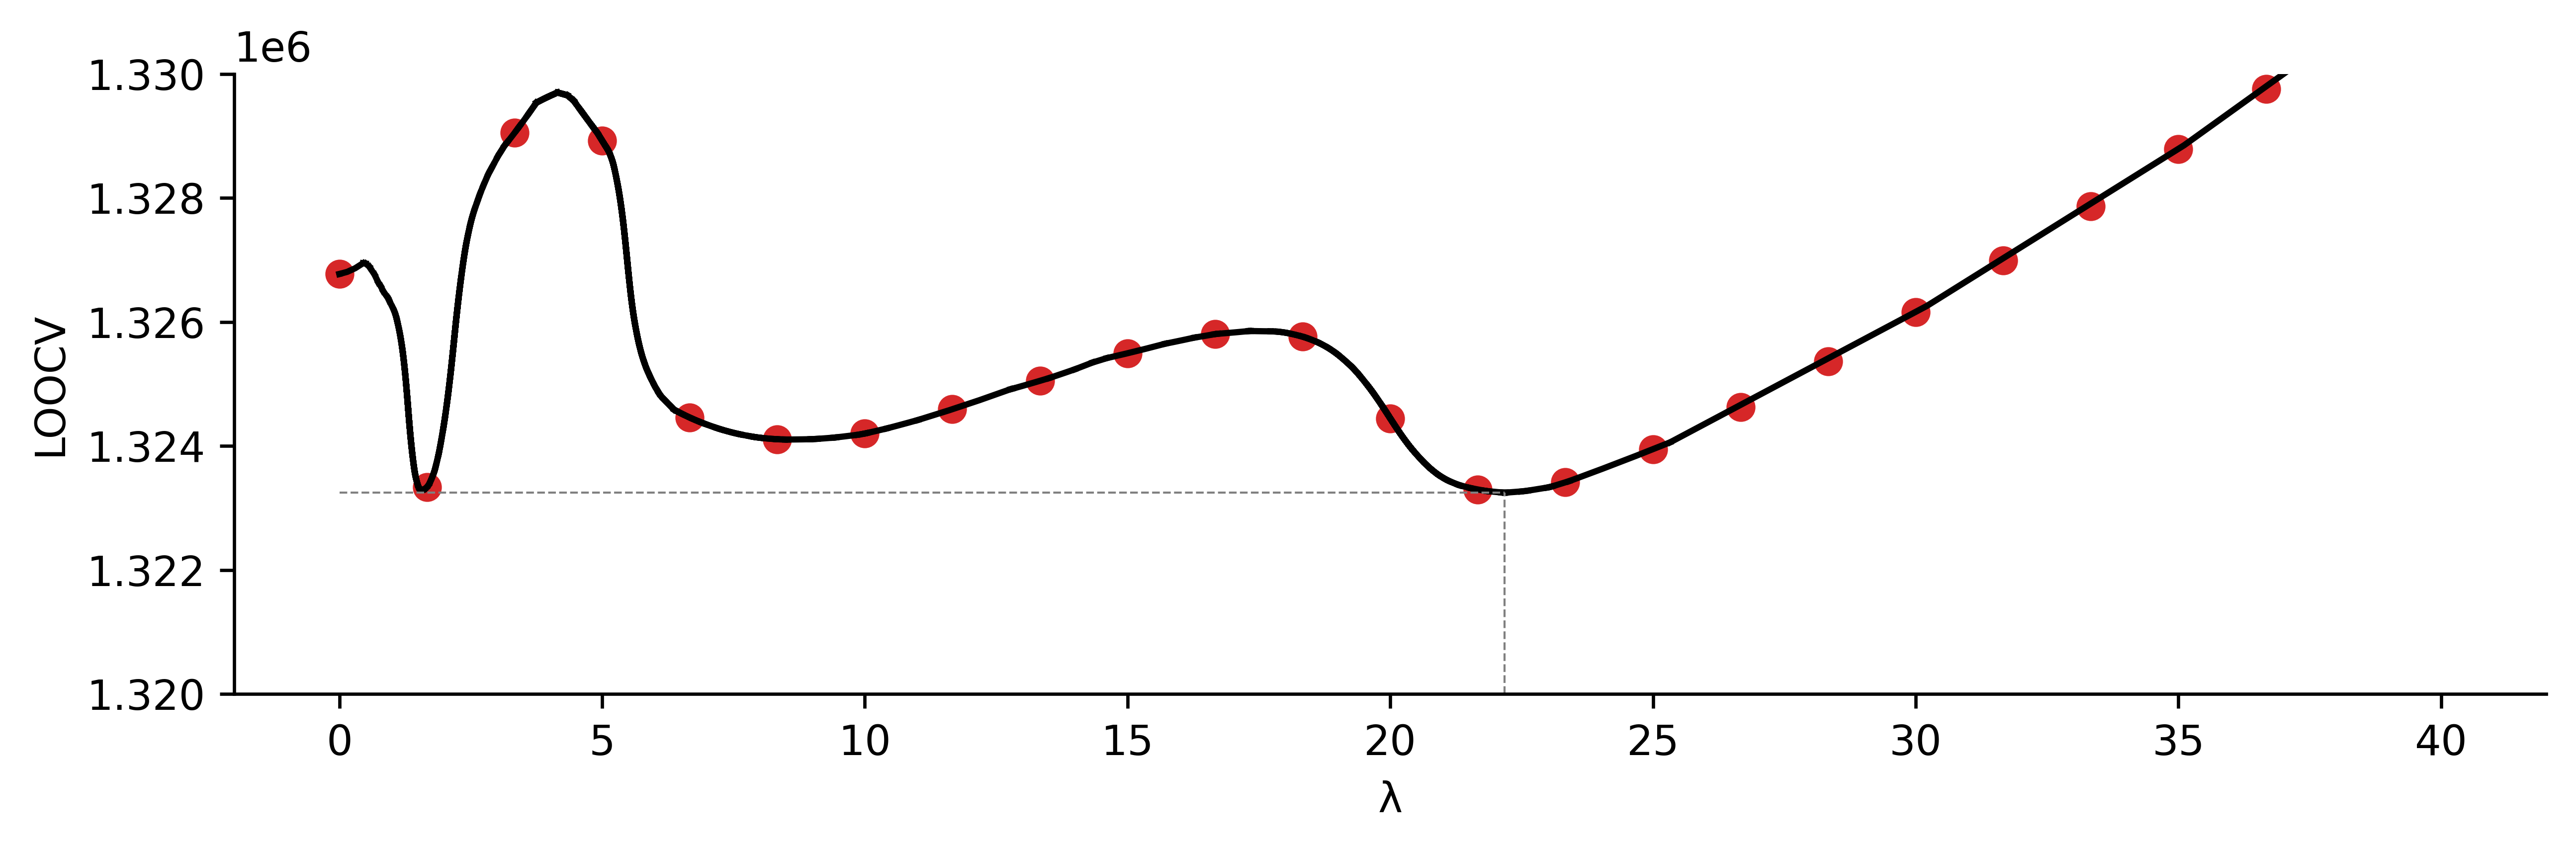

In [9]:
fig, ax = plt.subplots(figsize=(10, 2.7))
for lx, cx in zip(*model.loo_squared_error_.plot_points(0, 40)):
    ax.plot(lx, cx, color='black')
ax.scatter(lambdas, los, color='tab:red')
ax.set_ylim(1.32e6, 1.33e6)
lo_opt = model.loo_squared_error_.evaluate_lambda(model.lambda_)
ax.hlines(
    lo_opt, 
    0, model.lambda_, 
    color='grey', linewidth=0.5, linestyle='--')
ax.vlines(
    model.lambda_,
    ax.get_ylim()[0],
    lo_opt,
    color='grey', linewidth=0.5, linestyle='--')
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel('λ')
ax.set_ylabel('LOOCV')